In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 


In [4]:
df = pd.read_csv("C:/Users/Muhammed/Downloads/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking


In [6]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [7]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [8]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [9]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [10]:
#Check for Null values
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

## Exploratory Analysis

Data Preprocessing

In [11]:
#creating another instance because weekdays is mapped
data = pd.read_csv("C:/Users/Muhammed/Downloads/customer_booking.csv", encoding="ISO-8859-1")

In [12]:
# Separating categorical and numerical data
df_categorical = df.select_dtypes(include="object")
df_numerical = df.select_dtypes(exclude="object")

In [13]:
df_categorical.head()

,sales_channel,trip_type,route,booking_origin
0,Internet,RoundTrip,AKLDEL,New Zealand
1,Internet,RoundTrip,AKLDEL,New Zealand
2,Internet,RoundTrip,AKLDEL,India
3,Internet,RoundTrip,AKLDEL,New Zealand
4,Internet,RoundTrip,AKLDEL,India


Using One Hot Encoding

In [14]:
df_categorical.columns

Index(['sales_channel', 'trip_type', 'route', 'booking_origin'], dtype='object')

In [15]:
columns = ['sales_channel', 'trip_type', 'route', 'booking_origin']
for value in columns:
    df_categorical=pd.get_dummies(df_categorical, columns=[value],drop_first=True)

In [16]:
df_categorical.shape

(50000, 904)

In [17]:
df_categorical.head()

,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,route_AKLHGH,route_AKLHND,route_AKLICN,route_AKLKIX,route_AKLKTM,route_AKLKUL,route_AKLMRU,...,booking_origin_Timor-Leste,booking_origin_Tonga,booking_origin_Tunisia,booking_origin_Turkey,booking_origin_Ukraine,booking_origin_United Arab Emirates,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vanuatu,booking_origin_Vietnam
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Detecting Outliers

In [18]:
df_numerical.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,262,19,7,6,1,0,0,5.52,0
1,1,112,20,3,6,0,0,0,5.52,0
2,2,243,22,17,3,1,1,0,5.52,0
3,1,96,31,4,6,0,0,1,5.52,0
4,2,68,22,15,3,1,0,1,5.52,0


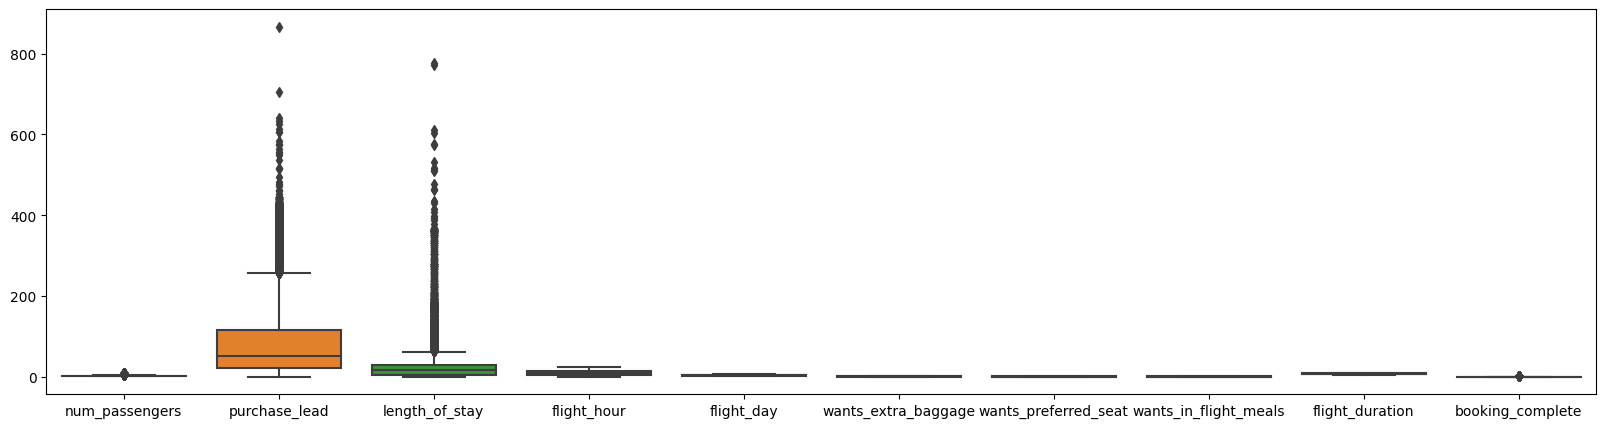

In [19]:
# Plotting boxplot for detecting outliers
plt.figure(figsize=(20,5))
sns.boxplot(data = df_numerical)
plt.show()

In [20]:
df_numerical.columns

Index(['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'flight_day', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')

Replacing outliers with the median of the data

In [21]:
# Replacing outliers with median
#function to return a list of index of outliers
column_list = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
       'flight_duration']
for feature in column_list:
    Q1= df_numerical[feature].quantile(0.25)
    Q3 =df_numerical[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    
    lower_limit = Q1 - 1.5 * IQR
    
    upper_limit = Q3 + 1.5 * IQR
  
    
    median = df_numerical[feature].median()
    
    df_numerical[feature] = np.where(df_numerical[feature]< lower_limit, median,df_numerical[feature])
    df_numerical[feature] = np.where(df_numerical[feature]> upper_limit, median,df_numerical[feature])

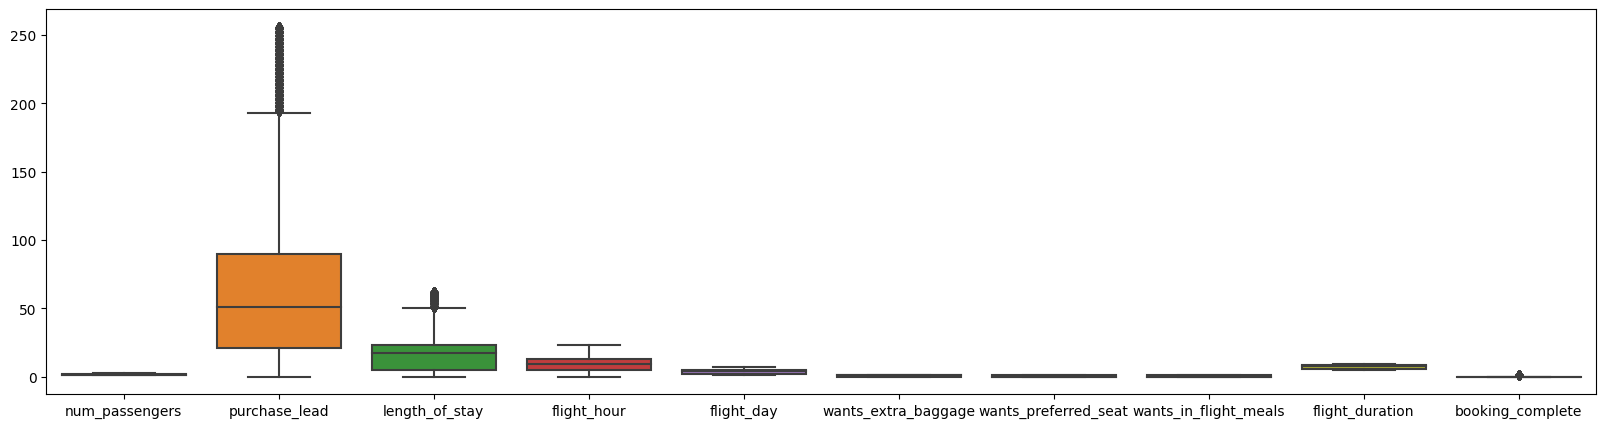

In [22]:
# Plotting boxplot for detecting outliers
plt.figure(figsize=(20,5))
sns.boxplot(data = df_numerical)
plt.show()

HeatMap

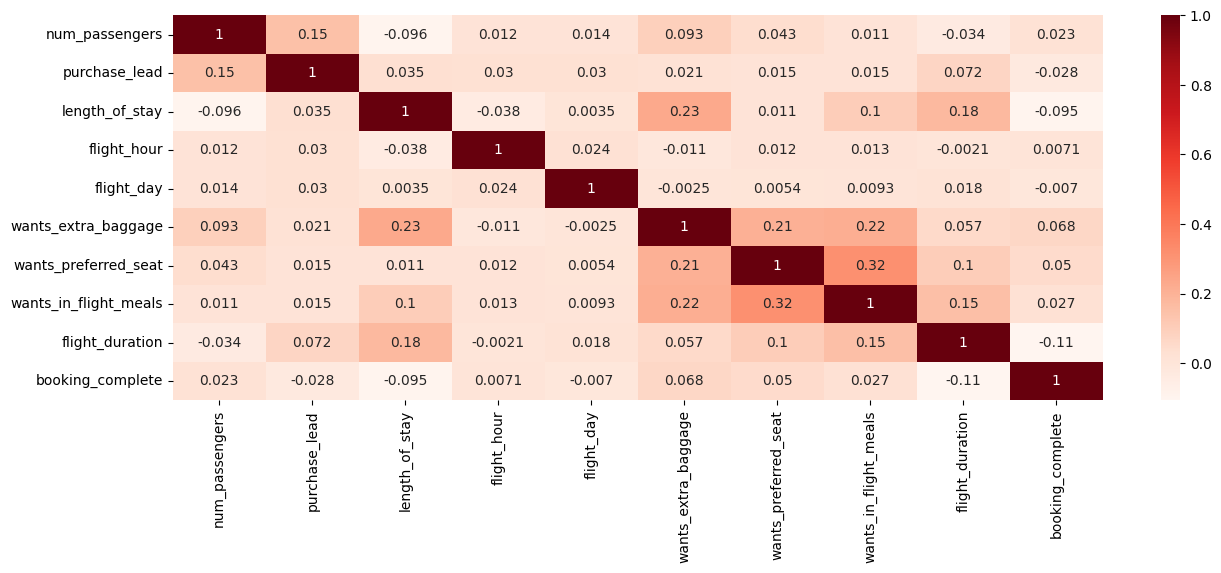

In [23]:
# Plotting heatmap 
plt.figure(figsize=(15,5))
sns.heatmap(df_numerical.corr() , annot=True, cmap="Reds")
plt.show()

Flights on Each Weekday

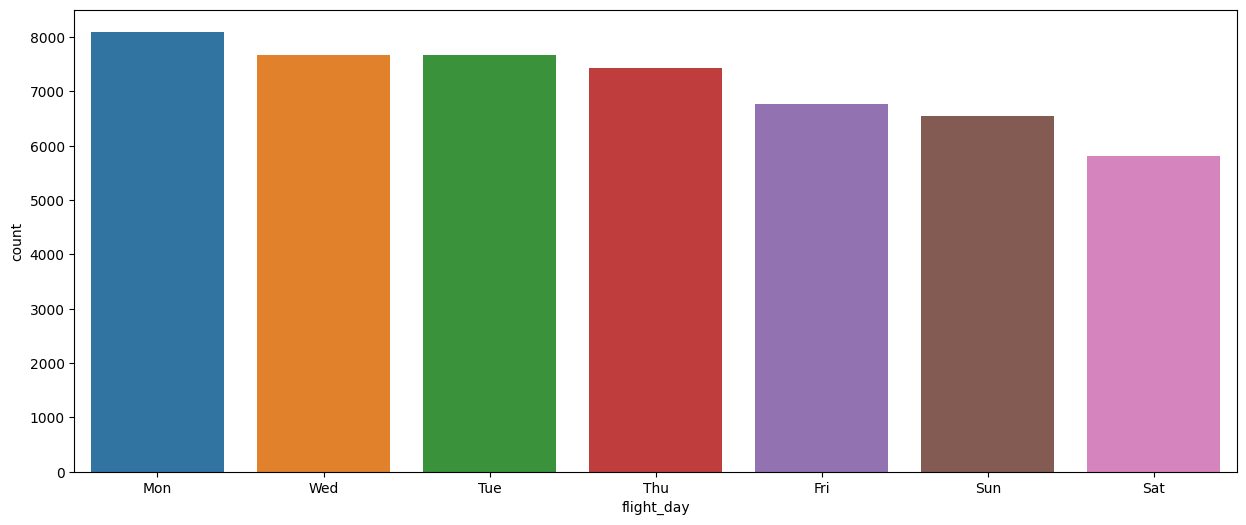

In [24]:
# No. of flights on each day of the week
plt.figure(figsize=(15,6))
sns.countplot(x = "flight_day", data=data, order=data["flight_day"].value_counts().index)
plt.show()

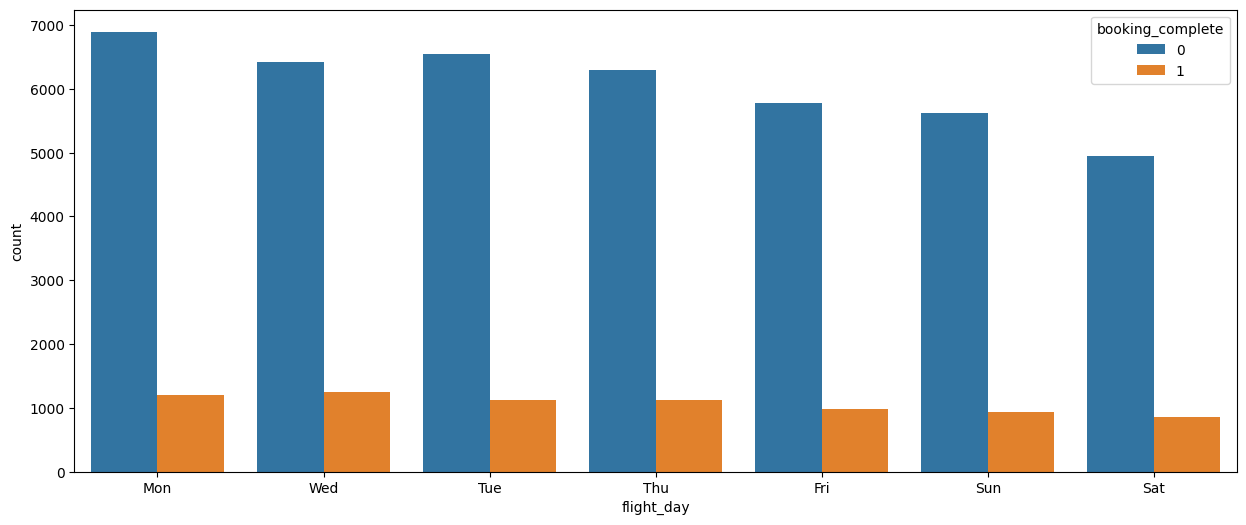

In [25]:
# No. of flights on each day of the week
plt.figure(figsize=(15,6))
sns.countplot(x = "flight_day",hue = "booking_complete", data=data, order=data["flight_day"].value_counts().index)
plt.show()

Booking Channels

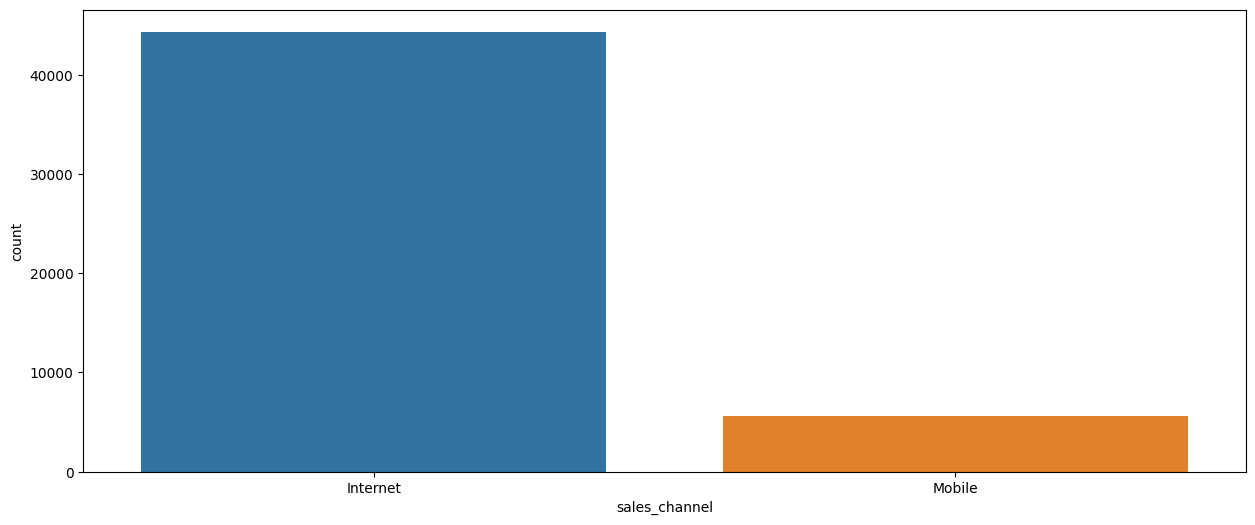

In [26]:
# Frequently used Booking channel
plt.figure(figsize=(15,6))
sns.countplot(x = "sales_channel", data=data, order=data["sales_channel"].value_counts().index)
plt.show()

Trip Types Used

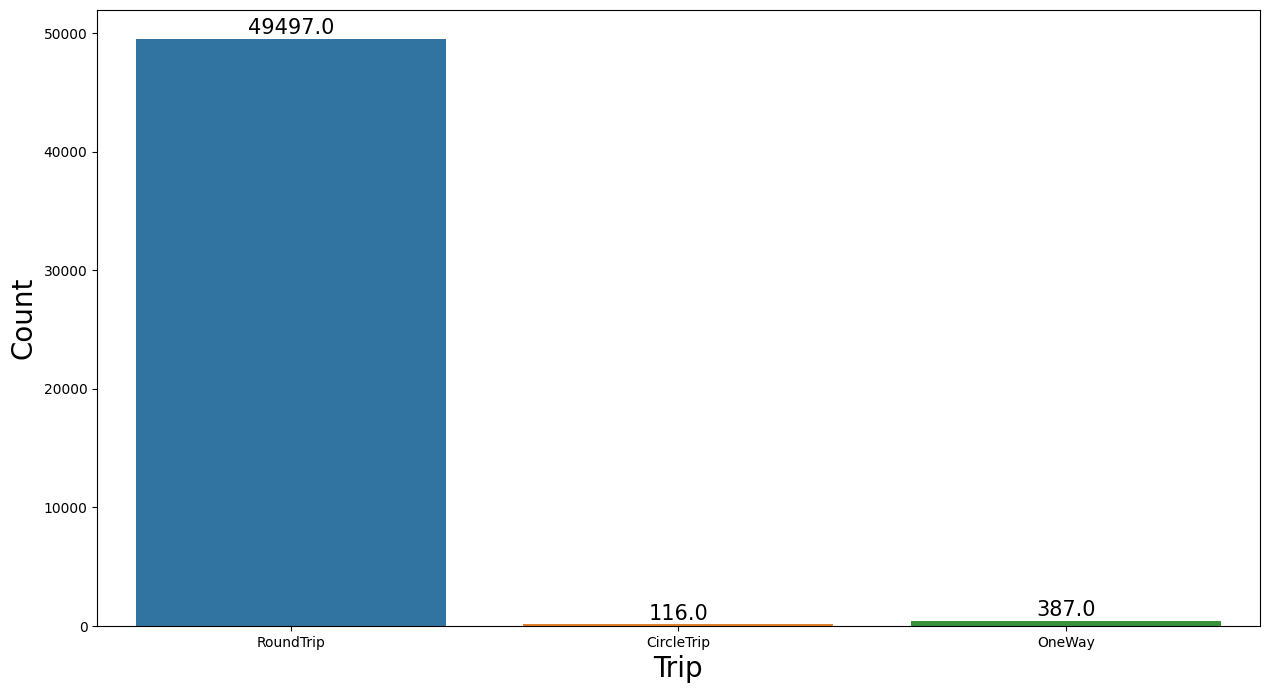

In [27]:
# Most frequently opted trip type
plt.figure(figsize=(15,8))
plots = sns.countplot(x="trip_type",  data=data)
plt.xlabel("Trip",fontsize= 20)
plt.ylabel("Count", fontsize= 20)

for bar in plots.patches:
    plots.annotate(format(bar.get_height()),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                   ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')  

Top Countires that Book Flights

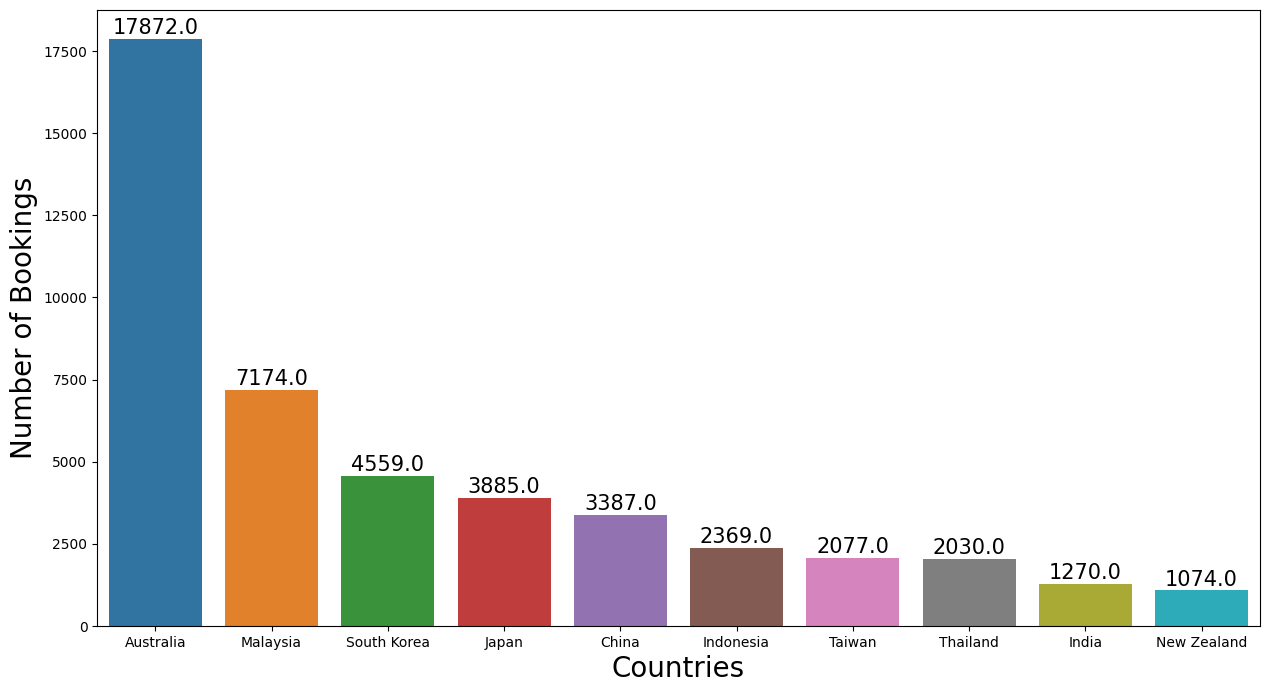

In [28]:
# Top 10 Countries in flight bookings
plt.figure(figsize=(15,8))
plots = sns.countplot(x="booking_origin",  data=data ,order=data.booking_origin.value_counts().iloc[:10].index)
plt.xlabel("Countries",fontsize= 20)
plt.ylabel("Number of Bookings", fontsize= 20)

for bar in plots.patches:
    plots.annotate(format(bar.get_height()),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                   ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')   

Mutual information 

In [29]:
# Separating dependent and independent variables
X = df.drop(["booking_complete"] , axis=1)
y = df["booking_complete"]

In [30]:
#Changing data type to int data type
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [31]:
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores # show a few features with their MI scores

route                    0.053362
booking_origin           0.047464
flight_duration          0.016497
length_of_stay           0.009760
num_passengers           0.006126
wants_extra_baggage      0.005812
wants_preferred_seat     0.005581
wants_in_flight_meals    0.003531
flight_hour              0.002576
trip_type                0.000325
sales_channel            0.000003
purchase_lead            0.000000
flight_day               0.000000
Name: MI Scores, dtype: float64

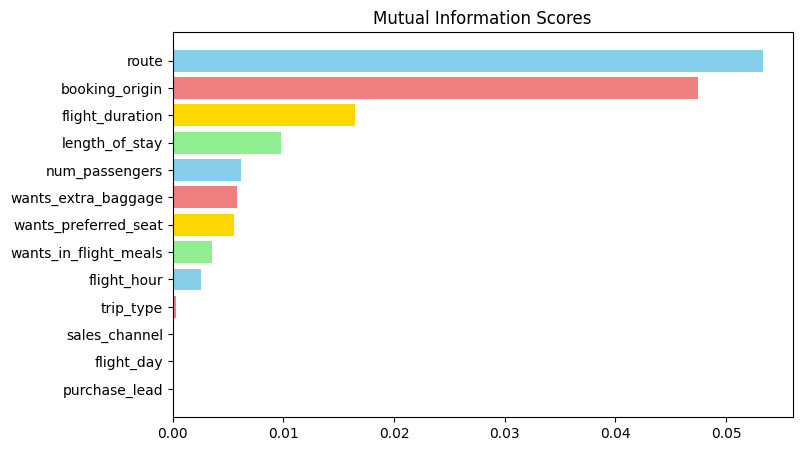

In [32]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores ,color=['skyblue', 'lightgreen', 'gold', 'lightcoral'])
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [33]:
def scaler(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    return X

In [34]:
def modelling(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
    return X_train, X_test, y_train, y_test

# XGBoost Model

In [35]:
#X = df.drop('booking_complete', axis=1)
X = pd.get_dummies(X)
X = scaler(X)
#y = df['booking_complete']

X_train, X_test, y_train, y_test = modelling(X,y)

In [36]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [37]:
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 0.1,
            'n_estimators':500
        }         
           
          
# instantiate the classifier 
model = XGBClassifier(**params)


# fit the classifier to the training data
model.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [38]:
y_pred = model.predict(X_test)

In [39]:

print('XGBoost model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
print('XGBoost model ROC score: {0:0.4f}'.format(roc_auc_score(y_test, y_pred)))

XGBoost model accuracy score: 0.8500
XGBoost model ROC score: 0.5350


In [40]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

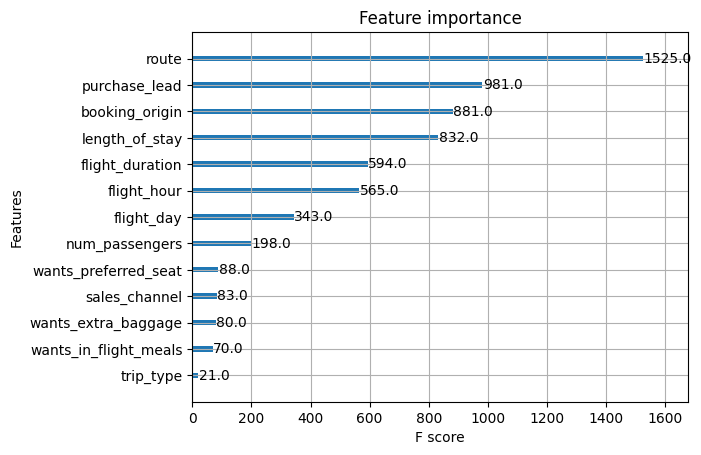

<Figure size 1600x1200 with 0 Axes>

In [41]:
xgb.plot_importance(model)
plt.figure(figsize = (16, 12))
plt.show()

In [42]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

In [43]:
imp = sorted(feature_important.items(), key=lambda x:x[1], reverse=True)

In [44]:
D = imp[:15]

In [45]:
D = pd.DataFrame(D)

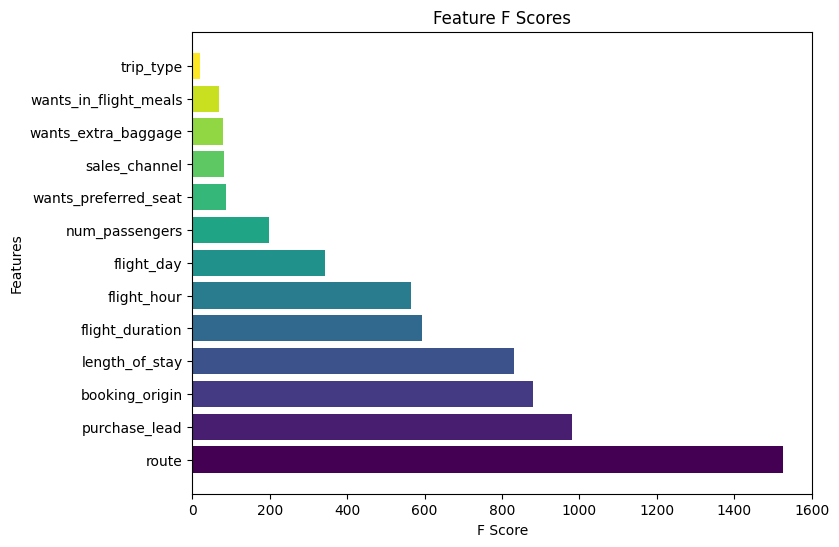

In [46]:
features = D.iloc[:, 0]
f_scores = D.iloc[:, 1]

# Create an array of indices to represent the bar positions
column_numbers = np.arange(len(features))

# Create a colormap with the number of colors you want (15 in this case)
colors = plt.cm.viridis(np.linspace(0, 1, len(features)))

# Create a horizontal bar chart using the colormap
plt.figure(figsize=(8, len(features) // 2))  # Adjust the figure size as needed
bars = plt.barh(column_numbers, f_scores, color=colors)
plt.yticks(column_numbers, features)  # Set the tick labels to feature names
plt.xlabel('F Score')
plt.ylabel('Features')
plt.title('Feature F Scores')


plt.show()